# Quantum Entanglement Swapping Protocol

## Swapping an entangled qubit - Simulation

In [1]:
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import transpile
from qiskit.result import Counts, marginal_counts
from qiskit.visualization import array_to_latex, plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# class QuantumNetwork:
#     pass

# class QuantumRepeater:
#     pass

class QuantumCircuitOperations:
    def __init__(self, barrier: bool = False):
        self.barrier = barrier
    
    def create_random_statevector(self, dimensions: int) -> Statevector:
        return random_statevector(dimensions)
    
    def create_bell_pairs(self, qc: QuantumCircuit, regs: list) -> None:
        if self.barrier: qc.barrier()
        for reg in regs:
            for q in range(reg.size):
                if q % 2 == 0:
                    qc.h(reg[q])
                    qc.cx(reg[q], reg[q + 1])
    
    def bell_state_operation(self, qc: QuantumCircuit, a: QuantumRegister, b: QuantumRegister,) -> None:
        if self.barrier: qc.barrier()
        qc.cx(a[1], b[0])
        qc.h(a[1])
    
    def bell_state_measurement(self, qc: QuantumCircuit, a: QuantumRegister, b: QuantumRegister) -> None:
        if self.barrier: qc.barrier()
        qc.measure(a[1], 0)
        qc.measure(b[0], 1)
    
    def pauli_correction_operation(self, qc: QuantumCircuit, b: QuantumRegister, crz: ClassicalRegister, crx: ClassicalRegister) -> None:
        # Apply the gates if the registers are in the state '1'
        if self.barrier: qc.barrier()
        qc.x(b[1]).c_if(crx, 1)
        qc.z(b[1]).c_if(crz, 1)


In [3]:
class QuantumVisualizations:
    def display_statevector_as_array(self, psi: Statevector) -> None:
        display(array_to_latex(psi, prefix="|\\psi\\rangle = "))
    
    def display_bloch_statevector(self, psi: Statevector):
        return plot_bloch_multivector(psi)

In [4]:
class QuantumNativeSimulations:
    def statevector_sim(self, qc: QuantumCircuit) -> Statevector:
        # returns the circuit statevector
        state_sim: StatevectorSimulator = StatevectorSimulator()
        return state_sim.run(transpile(qc, state_sim)).result().get_statevector()
    
    def qasm_sim(self, qc: QuantumCircuit) -> Counts:
        qasm_sim: QasmSimulator = QasmSimulator()
        return qasm_sim.run(transpile(qc, qasm_sim), shots=10000).result().get_counts()

In [5]:
alice: QuantumRegister = QuantumRegister(2, "alice")
bob: QuantumRegister = QuantumRegister(2, "bob")

crz: ClassicalRegister = ClassicalRegister(1, "crz")
crx: ClassicalRegister = ClassicalRegister(1, "crx")

coz: ClassicalRegister = ClassicalRegister(1, "coz")
cox: ClassicalRegister = ClassicalRegister(1, "cox")

qc: QuantumCircuit = QuantumCircuit(alice, bob, crz, crx, coz, cox)

<IPython.core.display.Latex object>

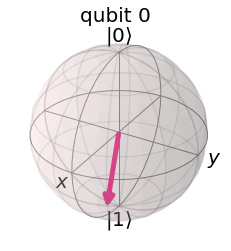

In [6]:
qco: QuantumCircuitOperations = QuantumCircuitOperations(True)
qv: QuantumVisualizations = QuantumVisualizations()

psi: Statevector = qco.create_random_statevector(2)

qv.display_statevector_as_array(psi)
qv.display_bloch_statevector(psi)

In [7]:
init_instruction: Initialize = Initialize(psi)
init_instruction.label = "init instruction"

qc.append(init_instruction, [alice[0]])

qco.create_bell_pairs(qc, [alice, bob])

# qc.append(init_instruction, [alice[0]])

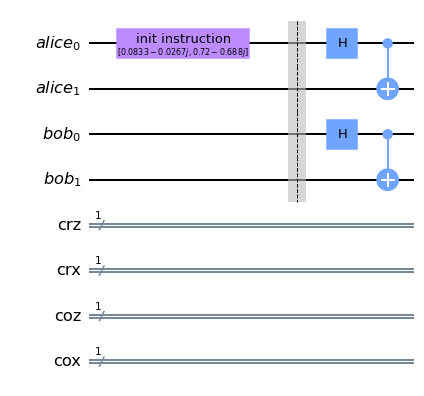

In [8]:
qc.draw("mpl")

<IPython.core.display.Latex object>

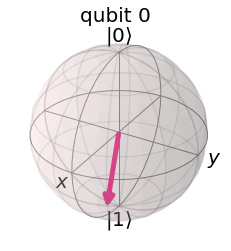

In [9]:
qns: QuantumNativeSimulations = QuantumNativeSimulations()

vector_state: Statevector = qns.statevector_sim(qc)

qv.display_statevector_as_array(psi)
qv.display_bloch_statevector(psi)

In [10]:
qco.bell_state_operation(qc, alice, bob)

In [11]:
qco.bell_state_measurement(qc, alice, bob)

In [12]:
qco.pauli_correction_operation(qc, bob, crz, crx)

In [13]:
vector_state: Statevector = qns.statevector_sim(qc)
qv.display_statevector_as_array(vector_state)

<IPython.core.display.Latex object>

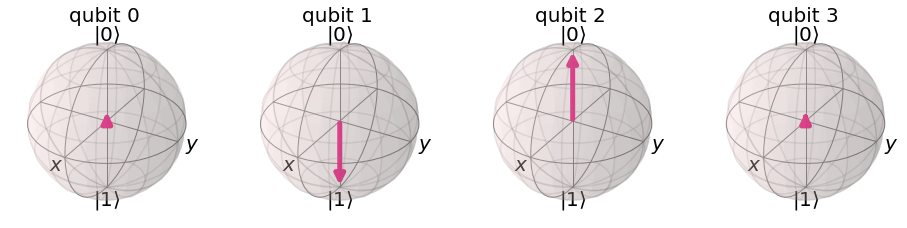

In [14]:
qv.display_bloch_statevector(vector_state)

In [15]:

qc.barrier()
qc.cx(alice[0], bob[1])
qc.h(alice[0])

<IPython.core.display.Latex object>

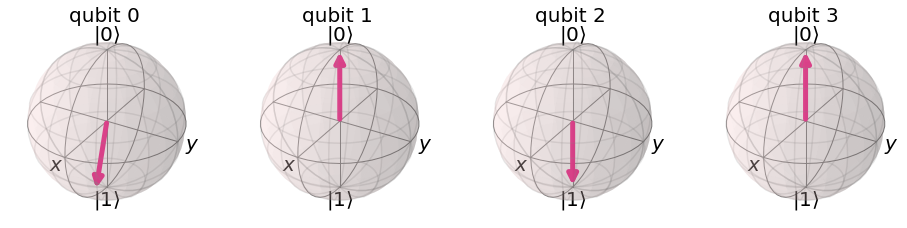

In [16]:
vector_state: Statevector = qns.statevector_sim(qc)
qv.display_statevector_as_array(vector_state)
qv.display_bloch_statevector(vector_state)

We wish to test that our circuit performed the protocol as is expected.

The Initialize instruction, reset our qubit to state, settings it to state $|0\rangle$, before applying gates to turn it from $|0\rangle$ to $|\psi\rangle$.

Since quantum gates are reversible, we can perform an inverse initialization operation, transforming our qubit from $|\psi\rangle$ to $|0\rangle$.

To prove entanglemnt swapping has occurred between Alice and Bob, Alice's first entangled qubit should have been teleported to Bob and entanglement established between $|alice_0\rangle$ and $|bob_1\rangle$. Performing a reverse initialization operation on $|alice_0\rangle$ on the entangled state $|alice_0bob_1\rangle$ now in Bob's node, we exect to measure the state $|00\rangle$ with certainty.

This operation/test acts as our test of entanglemnt swapping.

In [17]:
inverse_init_instruction: Initialize = init_instruction.gates_to_uncompute()

qc.barrier()
qc.append(inverse_init_instruction, [alice[0]])

In [18]:
qc.barrier()
qc.measure(alice[0], coz)
qc.measure(bob[1], cox)

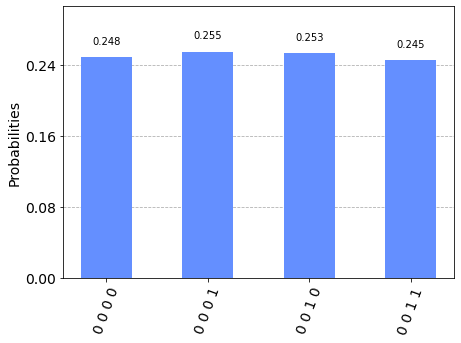

In [19]:
counts: Counts = qns.qasm_sim(qc)
plot_histogram(counts)
# print(counts)

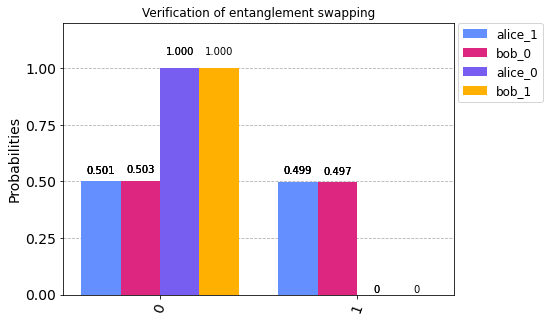

In [20]:
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(4)]
legend: list = ["alice_1", "bob_0", "alice_0", "bob_1"]
plot_histogram(qubit_counts, legend=legend, title="Verification of entanglement swapping")

As seen in the above graph, we have 100% probability of measuring our entangled qubit $|alice_0bob_1\rangle$ in the state $|00\rangle$. This is the expected result and indicates a successfull entanglement swapping protocol.

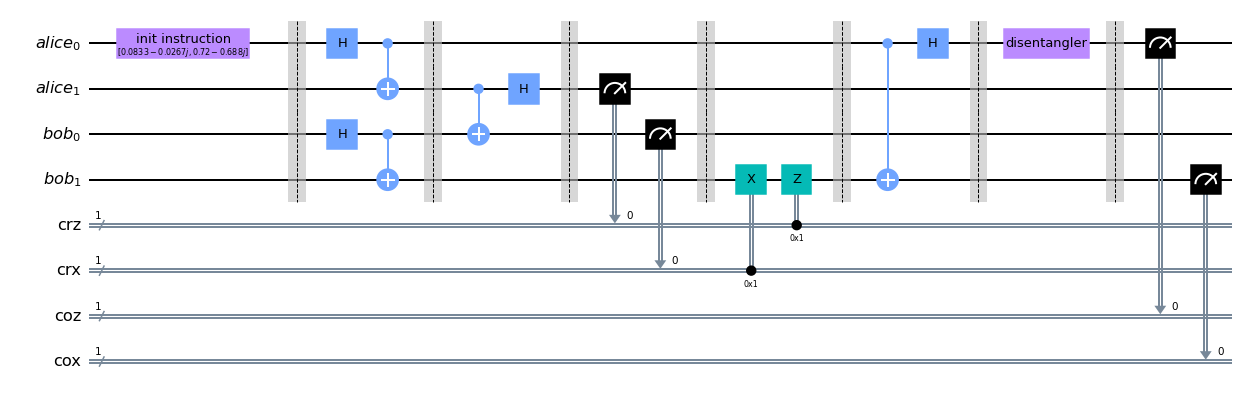

In [21]:
qc.draw("mpl")